In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import os

## Load Feature Group from Hopsworks

In [2]:
import hopsworks 
project = hopsworks.login()
fs = project.get_feature_store(name='recipe_recommender_featurestore')
review_fg = fs.get_feature_group('review', version=2)
recipe_fg = fs.get_feature_group('recipe', version=2)

2024-12-11 22:39:16,825 INFO: Initializing external client
2024-12-11 22:39:16,825 INFO: Base URL: https://c.app.hopsworks.ai:443
2024-12-11 22:39:23,326 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1193139


In [3]:
recipe_data = recipe_fg.read()

# Display the DataFrame
print(recipe_data.info())

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (708.99s) 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522517 entries, 0 to 522516
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   recipe_id            522517 non-null  int64  
 1   name                 522517 non-null  object 
 2   totaltime            522517 non-null  float64
 3   recipecategory       522517 non-null  object 
 4   aggregatedrating     522517 non-null  float64
 5   reviewcount          522517 non-null  float64
 6   calories             522517 non-null  float64
 7   fatcontent           522517 non-null  float64
 8   saturatedfatcontent  522517 non-null  float64
 9   cholesterolcontent   522517 non-null  float64
 10  sodiumcontent        522517 non-null  float64
 11  carbohydratecontent  522517 non-null  float64
 12  fibercontent         522517 non-null  float64
 13  sugarcontent         522517 non

In [4]:
review_data = pd.read_csv('..\\data\\reviews.csv')

print(review_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1401982 entries, 0 to 1401981
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   ReviewId       1401982 non-null  int64 
 1   RecipeId       1401982 non-null  int64 
 2   AuthorId       1401982 non-null  int64 
 3   AuthorName     1401982 non-null  object
 4   Rating         1401982 non-null  int64 
 5   Review         1401768 non-null  object
 6   DateSubmitted  1401982 non-null  object
 7   DateModified   1401982 non-null  object
dtypes: int64(4), object(4)
memory usage: 85.6+ MB
None


In [5]:
recipes = pd.read_csv('..\\data\\recipes.csv')

print(recipes.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522517 entries, 0 to 522516
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   RecipeId                    522517 non-null  int64  
 1   Name                        522517 non-null  object 
 2   AuthorId                    522517 non-null  int64  
 3   AuthorName                  522517 non-null  object 
 4   CookTime                    439972 non-null  object 
 5   PrepTime                    522517 non-null  object 
 6   TotalTime                   522517 non-null  object 
 7   DatePublished               522517 non-null  object 
 8   Description                 522512 non-null  object 
 9   Images                      522516 non-null  object 
 10  RecipeCategory              521766 non-null  object 
 11  Keywords                    505280 non-null  object 
 12  RecipeIngredientQuantities  522514 non-null  object 
 13  RecipeIngredie

In [6]:
review_data['Review'].fillna('', inplace=True) # Put empty description for now
review_data.drop(columns=['DateSubmitted', 'AuthorName'], inplace=True) # Only keep DateModified
review_data['DateModified'] = pd.to_datetime(review_data['DateModified'])
review_data['year'] = review_data['DateModified'].dt.year
review_data['month'] = review_data['DateModified'].dt.month
review_data['month_sin'] = np.sin(2 * np.pi * review_data['month'] / 12) # cyclic enconding for month (so Dec and Jan are close to one another)
review_data['month_cos'] = np.cos(2 * np.pi * review_data['month'] / 12)
review_data.drop(columns=['ReviewId', 'DateModified', 'month', 'Review'], inplace=True)
review_data.rename(columns={'AuthorId' : 'user_id', 'RecipeId' : 'recipe_id', 'Rating': 'rating'}, inplace=True)

In [7]:
review_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1401982 entries, 0 to 1401981
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   recipe_id  1401982 non-null  int64  
 1   user_id    1401982 non-null  int64  
 2   rating     1401982 non-null  int64  
 3   year       1401982 non-null  int32  
 4   month_sin  1401982 non-null  float64
 5   month_cos  1401982 non-null  float64
dtypes: float64(2), int32(1), int64(3)
memory usage: 58.8 MB


In [8]:
review_data = review_data.head(100_000)

In [9]:
combined_data = review_data.merge(recipe_data, on="recipe_id", how="left")

In [10]:
combined_data.head()

,recipe_id,user_id,rating,year,month_sin,month_cos,name,totaltime,recipecategory,aggregatedrating,reviewcount,calories,fatcontent,saturatedfatcontent,cholesterolcontent,sodiumcontent,carbohydratecontent,fibercontent,sugarcontent,proteincontent
0,992,2008,5,2000,0.500000,8.660254e-01,"[-0.10509939, -0.053312678, -0.050426587, 0.06...",-0.003597,"[-0.029408956, 0.010818674, -0.07821881, 0.070...",1.207007,0.815725,-0.267006,-0.138268,-0.099940,-0.207913,-0.141489,-0.253781,-0.376983,-0.147092,-0.328181
1,4384,1634,4,2001,-0.866025,5.000000e-01,"[-0.060209103, -0.005112475, -0.012842847, 0.0...",-0.002075,"[-0.00247523, -0.028400732, -0.026927572, 0.01...",1.207007,0.016539,-0.343450,-0.219893,-0.205039,-0.286393,-0.113227,-0.266500,-0.400230,-0.152701,-0.430352
2,4523,2046,2,2000,0.866025,5.000000e-01,"[-0.040666275, 0.042316977, 0.016736453, 0.043...",-0.003116,"[-0.046632297, -0.0098071555, -0.014670166, 0....",0.345601,0.482731,-0.045622,-0.169662,-0.175011,0.154354,0.311716,-0.019849,-0.295617,-0.011066,0.636214
3,7435,1773,5,2000,1.000000,6.123234e-17,"[-0.044769704, -0.0068349363, 0.037979748, -0....",0.000328,"[-0.030650476, 0.027059676, -0.008651573, 0.09...",1.207007,2.946885,0.194802,0.176570,0.108114,0.449069,0.479691,-0.041970,0.657521,-0.070665,0.735893
4,44,2085,5,2000,1.000000,6.123234e-17,"[-0.045681693, -0.038909838, -0.025304835, 0.0...",-0.003469,"[-0.04197564, -0.01328214, -0.038452026, 0.047...",1.207007,1.348515,0.294222,0.378390,0.479179,1.057374,-0.049972,-0.110546,-0.086392,-0.118344,0.693529


In [11]:
len(review_data['user_id'].unique())

15971

In [12]:
len(combined_data['recipe_id'].unique())

39507

In [13]:
# Create a mapping from user_id to indices
unique_user_ids = combined_data['user_id'].unique()
user_id_to_index = {user_id: idx for idx, user_id in enumerate(unique_user_ids)}

# Apply the mapping to the DataFrame or DataLoader
combined_data['user_id_index'] = combined_data['user_id'].map(user_id_to_index)


In [14]:
# Create a mapping from recipe_id to indices
unique_recipe_ids = combined_data['recipe_id'].unique()
recipe_id_to_index = {recipe_id: idx for idx, recipe_id in enumerate(unique_recipe_ids)}

# Apply the mapping to the DataFrame or DataLoader
combined_data['recipe_id_index'] = combined_data['recipe_id'].map(recipe_id_to_index)


In [15]:
combined_data['recipe_id_index'].head()

0    0
1    1
2    2
3    3
4    4
Name: recipe_id_index, dtype: int64

In [16]:
mean_rating = 0.001397
combined_data['label'] = (combined_data['rating'] > mean_rating).astype(int)

In [17]:
combined_data.head()

,recipe_id,user_id,rating,year,month_sin,month_cos,name,totaltime,recipecategory,aggregatedrating,...,saturatedfatcontent,cholesterolcontent,sodiumcontent,carbohydratecontent,fibercontent,sugarcontent,proteincontent,user_id_index,recipe_id_index,label
0,992,2008,5,2000,0.500000,8.660254e-01,"[-0.10509939, -0.053312678, -0.050426587, 0.06...",-0.003597,"[-0.029408956, 0.010818674, -0.07821881, 0.070...",1.207007,...,-0.099940,-0.207913,-0.141489,-0.253781,-0.376983,-0.147092,-0.328181,0,0,1
1,4384,1634,4,2001,-0.866025,5.000000e-01,"[-0.060209103, -0.005112475, -0.012842847, 0.0...",-0.002075,"[-0.00247523, -0.028400732, -0.026927572, 0.01...",1.207007,...,-0.205039,-0.286393,-0.113227,-0.266500,-0.400230,-0.152701,-0.430352,1,1,1
2,4523,2046,2,2000,0.866025,5.000000e-01,"[-0.040666275, 0.042316977, 0.016736453, 0.043...",-0.003116,"[-0.046632297, -0.0098071555, -0.014670166, 0....",0.345601,...,-0.175011,0.154354,0.311716,-0.019849,-0.295617,-0.011066,0.636214,2,2,1
3,7435,1773,5,2000,1.000000,6.123234e-17,"[-0.044769704, -0.0068349363, 0.037979748, -0....",0.000328,"[-0.030650476, 0.027059676, -0.008651573, 0.09...",1.207007,...,0.108114,0.449069,0.479691,-0.041970,0.657521,-0.070665,0.735893,3,3,1
4,44,2085,5,2000,1.000000,6.123234e-17,"[-0.045681693, -0.038909838, -0.025304835, 0.0...",-0.003469,"[-0.04197564, -0.01328214, -0.038452026, 0.047...",1.207007,...,0.479179,1.057374,-0.049972,-0.110546,-0.086392,-0.118344,0.693529,4,4,1


In [18]:
combined_data.shape

(100000, 23)

# Model Implementation

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset

## Dataset

In [20]:
class CombinedDataset(Dataset):
    def __init__(self, combined_df):
        """
        Args:
            reviews_df (pd.DataFrame): Dataframe containing the reviews data.
        """
        self.features = combined_df

    def __len__(self):
        # Return the total number of samples
        return len(self.features)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to fetch.
        Returns:
            A dictionary with tensors for the input features and target rating.
        """
        row = self.features.iloc[idx]
        
        # Extract features
        user_id = row["user_id"]
        user_id_index = row["user_id_index"]
        recipe_id = row["recipe_id"]
        recipe_id_index = row["recipe_id_index"]
        year = torch.tensor(row["year"], dtype=torch.float32)
        month_sin = torch.tensor(row["month_sin"], dtype=torch.float32)
        month_cos = torch.tensor(row["month_cos"], dtype=torch.float32)
        rating = torch.tensor(row["rating"], dtype=torch.float32)
        name_embedding = torch.tensor(row["name"], dtype=torch.float32)
        total_time = torch.tensor(row["totaltime"], dtype=torch.float32)
        category_embedding = torch.tensor(row["recipecategory"], dtype=torch.float32)
        aggr_rating = torch.tensor(row["aggregatedrating"], dtype=torch.float32)
        review_count = torch.tensor(row["reviewcount"], dtype=torch.float32)
        calories = torch.tensor(row["calories"], dtype=torch.float32)
        fat_content = torch.tensor(row["fatcontent"], dtype=torch.float32)
        saturated_fat_content = torch.tensor(row["saturatedfatcontent"], dtype=torch.float32)
        cholesterol_content = torch.tensor(row["cholesterolcontent"], dtype=torch.float32)
        sodium_content = torch.tensor(row["sodiumcontent"], dtype=torch.float32)
        carbohydrate_content = torch.tensor(row["carbohydratecontent"], dtype=torch.float32)
        fiber_content = torch.tensor(row["fibercontent"], dtype=torch.float32)
        sugar_content = torch.tensor(row["sugarcontent"], dtype=torch.float32)
        protein_content = torch.tensor(row["proteincontent"], dtype=torch.float32)
        label = row["label"]
        return {
            "user_id": user_id,
            "user_id_index": user_id_index,
            "recipe_id": recipe_id,
            "recipe_id_index": recipe_id_index,
            "year": year,
            "month_sin": month_sin,
            "month_cos": month_cos,
            "rating": rating,
            "name_embedding": name_embedding,
            "total_time": total_time,
            "category_embedding": category_embedding,
            "aggr_rating": aggr_rating,
            "calories": calories,
            "review_count" : review_count,
            "fat_content": fat_content,
            "saturated_fat_content": saturated_fat_content,
            "cholesterol_content": cholesterol_content,
            "sodium_content" : sodium_content,
            "carbohydrate_content" : carbohydrate_content,
            "fiber_content" : fiber_content,
            "sugar_content" : sugar_content,
            "protein_content" : protein_content,
            "label" : label
        }

In [36]:
class RecipeDataset(Dataset):
    def __init__(self, recipes_df):
        """
        Args:
            recipes_df (pd.DataFrame): Dataframe containing the reviews data.
        """
        self.recipes_df = recipes_df

    def __len__(self):
        # Return the total number of samples
        return len(self.recipes_df)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to fetch.
        Returns:
            A dictionary with tensors for the input features and target rating.
        """
        row = self.recipes_df.iloc[idx]

        # Extract features
        recipe_id = row["recipeid"]
        name_embedding = torch.tensor(row["name"], dtype=torch.float32)
        author_id = row["authorid"]
        total_time = torch.tensor(row["totaltime"], dtype=torch.float32)
        category_embedding = torch.tensor(row["recipecategory"], dtype=torch.float32)
        aggr_rating = torch.tensor(row["aggregatedrating"], dtype=torch.float32)
        review_count = torch.tensor(row["reviewcount"], dtype=torch.float32)
        calories = torch.tensor(row["calories"], dtype=torch.float32)
        fat_content = torch.tensor(row["fatcontent"], dtype=torch.float32)
        saturated_fat_content = torch.tensor(row["saturatedfatcontent"], dtype=torch.float32)
        cholesterol_content = torch.tensor(row["cholesterolcontent"], dtype=torch.float32)
        sodium_content = torch.tensor(row["sodiumcontent"], dtype=torch.float32)
        carbohydrate_content = torch.tensor(row["carbohydratecontent"], dtype=torch.float32)
        fiber_content = torch.tensor(row["fibercontent"], dtype=torch.float32)
        sugar_content = torch.tensor(row["sugarcontent"], dtype=torch.float32)
        protein_content = torch.tensor(row["proteincontent"], dtype=torch.float32)

        return {
            "recipe_id": recipe_id,
            "name_embedding": name_embedding,
            "author_id": author_id,
            "total_time": total_time,
            "category_embedding": category_embedding,
            "aggr_rating": aggr_rating,
            "calories": calories,
            "review_count" : review_count,
            "fat_content": fat_content,
            "saturated_fat_content": saturated_fat_content,
            "cholesterol_content": cholesterol_content,
            "sodium_content" : sodium_content,
            "carbohydrate_content" : carbohydrate_content,
            "fiber_content" : fiber_content,
            "sugar_content" : sugar_content,
            "protein_content" : protein_content
        }

## User Tower

In [21]:
class UserTower(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        """
        Args:
            num_embeddings (int): Number of user embeddings.
            embedding_dim (int): Dimensionality of the output embedding vector.
        """
        super(UserTower, self).__init__()
        self.embedding_dim = embedding_dim
        
        self.user_embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=self.embedding_dim)
        
        # Fully connected layers for the user tower
        self.fc1 = nn.Linear(embedding_dim + 4, 128)  # embedding_dim + month_sin, month_cos, year, rating
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, embedding_dim)  # Final embedding layer

    def forward(self, user_id, month_sin=None, month_cos=None, year=None, rating=None):
        """
        Forward pass for the User Tower.
        
        Args:
            user_id (Tensor): User ID tensor.
            month_sin (Tensor, optional): Sinusoidal month feature.
            month_cos (Tensor, optional): Cosine month feature.
            year (Tensor, optional): Year feature.
            rating (Tensor, optional): Rating given to recipe.
        
        Returns:
            Tensor: user review embedding of size embedding_dim.
        """
        # Get user embedding from user_id
        user_id_embedding = self.user_embedding(user_id)
        
        # During inference (not training), we just return the user_id_embedding
        if not self.training:
            return user_id_embedding
        
        # If we are in training, concatenate additional features
        if month_sin is not None and month_cos is not None and year is not None and rating is not None:
            # Concatenate all features (now all are 2D tensors)
            x = torch.cat((user_id_embedding, month_sin.unsqueeze(1), month_cos.unsqueeze(1), year.unsqueeze(1), rating.unsqueeze(1)), dim=1)
        else:
            # If features are missing (this should not happen during training), just return the user embedding
            return user_id_embedding
        
        # Pass through fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Final embedding vector
        return x

## Item Tower

In [22]:
class ItemTower(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, recipe_embedding_dim):
        """
        Args:
            review_vector_dim (int): Dimensionality of the review feature vector.
            embedding_dim (int): Dimensionality of the output embedding vector.
        """
        super(ItemTower, self).__init__()
        
        self.embedding_dim = embedding_dim
        
        self.item_embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=self.embedding_dim)
        
        self.fc1 = nn.Linear(embedding_dim + recipe_embedding_dim * 2 + 12, 128)  # Add month_sin, month_cos, and year, and rating
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, embedding_dim)  # Final embedding layer

    def forward(self, recipe_id, name_embedding, total_time, category_embedding,
                aggr_rating, review_count, calories, fat_content, saturated_fat_content,
                cholesterol_content, sodium_content, carbohydrate_content, fiber_content,
                sugar_content, protein_content
                ):
        """
        Forward pass for the recipe tower.
        
        Args:
            name_embedding (Tensor): Embedding made for the recipe name.
            author_id (Tensor): ID for the author.
            total_time (Tensor): Parsed total time taken to prepare the recipe.
            category_embedding (Tensor): Embedding made for the recipe category.
            aggr_rating (Tensor): Average rating for the recipe.
            review_count (Tensor): Count of reviews for the recipe.
            (The rest are very self-explanatory)
        
        Returns:
            Tensor: Embedded vector for the review.
        """
        recipe_id = recipe_id.long()
        
        item_id_embedding = self.item_embedding(recipe_id)
        
        # Concatenate all features
        x = torch.cat((
        item_id_embedding,
        name_embedding, 
        total_time.unsqueeze(1), 
        category_embedding, 
        aggr_rating.unsqueeze(1), 
        review_count.unsqueeze(1), 
        calories.unsqueeze(1), 
        fat_content.unsqueeze(1), 
        saturated_fat_content.unsqueeze(1), 
        cholesterol_content.unsqueeze(1), 
        sodium_content.unsqueeze(1), 
        carbohydrate_content.unsqueeze(1), 
        fiber_content.unsqueeze(1), 
        sugar_content.unsqueeze(1), 
        protein_content.unsqueeze(1)
        ), dim=1)
    
        # Pass through fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Final embedding vector
        return x


## Dataloaders

In [23]:
from torch.utils.data import DataLoader

NUM_USERS = 15971
NUM_RECIPES = 39507 # len(combined_data['recipe_id'].unique())

batch_size = 32

# Create review and recipe dataloaders
# Create the dataset
dataset = CombinedDataset(combined_data)


# Define dimensions
embedding_dim = 32  # Size of the output embedding vector (arbitrary, tunable)
recipe_embedding_dim = 384  # Dimensionality of the "review" feature

# Initialize the model
user_tower = UserTower(num_embeddings=NUM_USERS, embedding_dim=embedding_dim)
item_tower = ItemTower(num_embeddings=NUM_RECIPES, embedding_dim=embedding_dim, recipe_embedding_dim=recipe_embedding_dim)

# Create a DataLoader for batching
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


# Example: Iterate through the DataLoader
for batch in dataloader:
    user_embeddings = user_tower(batch["user_id_index"], batch["month_sin"], batch["month_cos"], batch["year"], batch["rating"])
    item_embeddings = item_tower(
        batch["recipe_id_index"],
        batch["name_embedding"],  
        batch["total_time"], 
        batch["category_embedding"], 
        batch["aggr_rating"],
        batch["review_count"], 
        batch["calories"], 
        batch["fat_content"], 
        batch["saturated_fat_content"], 
        batch["cholesterol_content"], 
        batch["sodium_content"], 
        batch["carbohydrate_content"], 
        batch["fiber_content"], 
        batch["sugar_content"], 
        batch["protein_content"]
    )
    print("User Embedding shape:", user_embeddings.shape)
    print(user_embeddings)
    print("Item Embedding shape:", item_embeddings.shape)
    print(item_embeddings)
    break

User Embedding shape: torch.Size([32, 32])
tensor([[-72.4833,  32.5365,  25.5362,  ..., -17.2842,  24.8866, -64.3908],
        [-72.6145,  32.7158,  25.4606,  ..., -17.2961,  24.7523, -64.4166],
        [-72.3085,  32.3533,  25.5840,  ..., -17.1529,  24.9776, -64.1700],
        ...,
        [-72.3801,  32.6291,  25.5327,  ..., -17.2105,  24.6026, -64.3085],
        [-72.6608,  32.6305,  25.3865,  ..., -17.1698,  24.7820, -64.3469],
        [-72.6562,  32.7243,  25.3833,  ..., -17.2108,  24.9251, -64.4612]],
       grad_fn=<AddmmBackward0>)
Item Embedding shape: torch.Size([32, 32])
tensor([[-0.0323, -0.0758,  0.0312,  ..., -0.0329, -0.1309,  0.0827],
        [ 0.0289, -0.0650,  0.0087,  ..., -0.0268, -0.0939,  0.0540],
        [ 0.0412, -0.0541,  0.0201,  ..., -0.0643, -0.1040,  0.0773],
        ...,
        [ 0.0453, -0.0457,  0.0304,  ..., -0.0471, -0.1041,  0.0808],
        [ 0.0217, -0.0820,  0.0258,  ..., -0.0642, -0.1076,  0.0808],
        [ 0.0368, -0.0532,  0.0169,  ..., -0.029

## Embeddings for Paired Dataset

## Two-Tower Model

In [24]:
class TwoTowerRecommender(nn.Module):
    def __init__(self):
        super(TwoTowerRecommender, self).__init__()

    def forward(self, user_embedding, item_embedding):
        # Compute cosine similarity
        similarity = F.cosine_similarity(user_embedding, item_embedding, dim=1)
        # scale from [-1, 1] to [0, 1] for BCE loss
        similarity = torch.clamp(0.5 * (similarity + 1), min=0, max=1)
        return similarity


# Training

## Training Loop

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [28]:
from tqdm import tqdm

# Define the number of epochs and learning rate
num_epochs = 10
learning_rate = 1e-3

# Initialize models
user_tower = UserTower(num_embeddings=NUM_USERS, embedding_dim=embedding_dim)
item_tower = ItemTower(num_embeddings=NUM_RECIPES, embedding_dim=embedding_dim, recipe_embedding_dim=recipe_embedding_dim)
model = TwoTowerRecommender()

# Define optimizer
optimizer = optim.Adam(list(user_tower.parameters()) + list(item_tower.parameters()), lr=learning_rate)

# Define loss function
loss_fn = nn.BCELoss()  # Binary Cross-Entropy Loss

# Set models to training mode
user_tower.train()
item_tower.train()
model.train()

epoch_losses = []

# Create DataLoader for the dataset
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(num_epochs):
    total_loss = 0.0
    for batch in tqdm(dataloader):
        # Extract input data
        user_embeddings = user_tower(
            batch["user_id_index"], 
            batch["month_sin"], 
            batch["month_cos"], 
            batch["year"], 
            batch["rating"]
        )
        item_embeddings = item_tower(
            batch["recipe_id_index"],
            batch["name_embedding"],  
            batch["total_time"], 
            batch["category_embedding"], 
            batch["aggr_rating"],
            batch["review_count"], 
            batch["calories"], 
            batch["fat_content"], 
            batch["saturated_fat_content"], 
            batch["cholesterol_content"], 
            batch["sodium_content"], 
            batch["carbohydrate_content"], 
            batch["fiber_content"], 
            batch["sugar_content"], 
            batch["protein_content"]
        )
        
        # Compute cosine similarity
        similarity = model(user_embeddings, item_embeddings)
        
        # Target labels
        labels = batch["label"].float()  # Ensure labels are float for BCE Loss
        
        # Compute loss
        loss = loss_fn(similarity, labels)
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        total_loss += loss.item()
    
    # Print epoch loss
    epoch_loss = total_loss / len(dataloader)
    epoch_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

print("Training complete.")

100%|██████████| 3125/3125 [01:00<00:00, 51.82it/s]


Epoch 1/50, Loss: 0.1221


100%|██████████| 3125/3125 [00:56<00:00, 55.09it/s]


Epoch 2/50, Loss: 0.0070


100%|██████████| 3125/3125 [00:56<00:00, 54.89it/s]


Epoch 3/50, Loss: 0.0000


100%|██████████| 3125/3125 [00:57<00:00, 54.76it/s]


Epoch 4/50, Loss: 0.0000


100%|██████████| 3125/3125 [00:58<00:00, 53.82it/s]


Epoch 5/50, Loss: 0.0000


100%|██████████| 3125/3125 [00:57<00:00, 54.05it/s]


Epoch 6/50, Loss: 0.0016


100%|██████████| 3125/3125 [00:57<00:00, 54.52it/s]


Epoch 7/50, Loss: 0.0000


100%|██████████| 3125/3125 [00:57<00:00, 54.55it/s]


Epoch 8/50, Loss: 0.0000


100%|██████████| 3125/3125 [00:56<00:00, 55.62it/s] 


Epoch 9/50, Loss: 0.0013


100%|██████████| 3125/3125 [00:57<00:00, 54.42it/s]


Epoch 10/50, Loss: 0.0022


100%|██████████| 3125/3125 [00:57<00:00, 53.94it/s]


Epoch 11/50, Loss: 0.0000


100%|██████████| 3125/3125 [00:57<00:00, 54.69it/s]


Epoch 12/50, Loss: 0.0020


100%|██████████| 3125/3125 [00:56<00:00, 54.83it/s]


Epoch 13/50, Loss: 0.0092


100%|██████████| 3125/3125 [00:57<00:00, 54.59it/s]


Epoch 14/50, Loss: 0.0000


100%|██████████| 3125/3125 [00:57<00:00, 54.36it/s]


Epoch 15/50, Loss: 0.0000


100%|██████████| 3125/3125 [00:57<00:00, 54.43it/s]


Epoch 16/50, Loss: 0.0000


100%|██████████| 3125/3125 [00:57<00:00, 54.38it/s]


Epoch 17/50, Loss: 0.0052


100%|██████████| 3125/3125 [00:57<00:00, 54.82it/s]


Epoch 18/50, Loss: 0.0000


100%|██████████| 3125/3125 [00:56<00:00, 54.92it/s]


Epoch 19/50, Loss: 0.0023


100%|██████████| 3125/3125 [00:57<00:00, 54.67it/s]


Epoch 20/50, Loss: 0.0006


100%|██████████| 3125/3125 [00:57<00:00, 54.58it/s]


Epoch 21/50, Loss: 0.0000


100%|██████████| 3125/3125 [00:56<00:00, 54.99it/s]


Epoch 22/50, Loss: 0.0000


100%|██████████| 3125/3125 [00:56<00:00, 55.35it/s]


Epoch 23/50, Loss: 0.0032


100%|██████████| 3125/3125 [00:56<00:00, 55.39it/s]


Epoch 24/50, Loss: 0.0006


100%|██████████| 3125/3125 [00:56<00:00, 55.19it/s]


Epoch 25/50, Loss: 0.0000


100%|██████████| 3125/3125 [00:56<00:00, 55.40it/s]


Epoch 26/50, Loss: 0.0000


100%|██████████| 3125/3125 [00:56<00:00, 55.06it/s]


Epoch 27/50, Loss: 0.0023


100%|██████████| 3125/3125 [00:56<00:00, 55.14it/s]


Epoch 28/50, Loss: 0.0000


100%|██████████| 3125/3125 [00:56<00:00, 55.15it/s]


Epoch 29/50, Loss: 0.0000


100%|██████████| 3125/3125 [00:56<00:00, 55.01it/s]


Epoch 30/50, Loss: 0.0070


100%|██████████| 3125/3125 [00:56<00:00, 55.10it/s]


Epoch 31/50, Loss: 0.0043


100%|██████████| 3125/3125 [00:56<00:00, 55.24it/s]


Epoch 32/50, Loss: 0.0000


100%|██████████| 3125/3125 [00:56<00:00, 54.91it/s]


Epoch 33/50, Loss: 0.0000


100%|██████████| 3125/3125 [00:56<00:00, 55.01it/s]


Epoch 34/50, Loss: 0.0000


100%|██████████| 3125/3125 [00:56<00:00, 55.00it/s]


Epoch 35/50, Loss: 0.0023


100%|██████████| 3125/3125 [00:56<00:00, 54.94it/s]


Epoch 36/50, Loss: 0.0009


100%|██████████| 3125/3125 [00:57<00:00, 54.76it/s]


Epoch 37/50, Loss: 0.0010


100%|██████████| 3125/3125 [00:56<00:00, 54.98it/s]


Epoch 38/50, Loss: 0.0000


100%|██████████| 3125/3125 [00:56<00:00, 54.89it/s]


Epoch 39/50, Loss: 0.0000


100%|██████████| 3125/3125 [00:56<00:00, 55.11it/s]


Epoch 40/50, Loss: 0.0000


100%|██████████| 3125/3125 [00:56<00:00, 54.87it/s]


Epoch 41/50, Loss: 0.0018


100%|██████████| 3125/3125 [00:56<00:00, 54.88it/s]


Epoch 42/50, Loss: 0.0000


100%|██████████| 3125/3125 [09:21<00:00,  5.57it/s]   


Epoch 43/50, Loss: 0.0000


100%|██████████| 3125/3125 [00:59<00:00, 52.55it/s]


Epoch 44/50, Loss: 0.0012


100%|██████████| 3125/3125 [00:58<00:00, 53.33it/s]


Epoch 45/50, Loss: 0.0012


100%|██████████| 3125/3125 [00:57<00:00, 54.55it/s]


Epoch 46/50, Loss: 0.0000


100%|██████████| 3125/3125 [00:57<00:00, 54.50it/s]


Epoch 47/50, Loss: 0.0000


100%|██████████| 3125/3125 [00:57<00:00, 54.62it/s]


Epoch 48/50, Loss: 0.0012


100%|██████████| 3125/3125 [00:57<00:00, 54.31it/s]


Epoch 49/50, Loss: 0.0004


100%|██████████| 3125/3125 [00:57<00:00, 54.37it/s]

Epoch 50/50, Loss: 0.0046
Training complete.


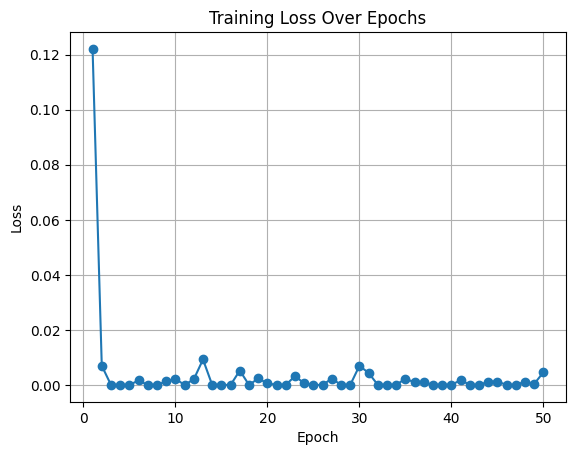

In [35]:
# Plot the training loss
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Inference

In [29]:
def recommend_recipes(user_id, user_tower, item_tower, recipe_dataloader, num_recommendations=5):
    # Step 1: Get the user embedding from the UserTower
    user_embedding = user_tower(user_id).squeeze(0)  # Remove the extra dimension for batch size
    
    # Check the shape of the user_embedding
    print(f"user_embedding shape: {user_embedding.shape}")
    
    # Step 2: Get embeddings for all recipes (you can loop through the dataset or batch them)
    all_recipe_embeddings = []
    all_recipe_ids = []  # Store corresponding recipe ids
    for batch in tqdm(recipe_dataloader):  # Iterate through DataFrame rows
        # Extract the values from the row (each row is a pandas Series)
        recipe_embedding = item_tower(
            batch["recipe_id_index"],
            batch["name_embedding"],  
            batch["total_time"], 
            batch["category_embedding"], 
            batch["aggr_rating"],
            batch["review_count"], 
            batch["calories"], 
            batch["fat_content"], 
            batch["saturated_fat_content"], 
            batch["cholesterol_content"], 
            batch["sodium_content"], 
            batch["carbohydrate_content"], 
            batch["fiber_content"], 
            batch["sugar_content"], 
            batch["protein_content"]
        )

        # Step 4: Append recipe embeddings and IDs for each batch
        all_recipe_embeddings.append(recipe_embedding)
        all_recipe_ids.extend(batch["recipe_id"].tolist())  # Add recipe IDs as a list

    # Step 5: Concatenate all recipe embeddings into a single tensor (batch-wise)
    all_recipe_embeddings = torch.cat(all_recipe_embeddings, dim=0)
    
    # Check the shape of all_recipe_embeddings
    print(f"all_recipe_embeddings shape: {all_recipe_embeddings.shape}")
    
    print(user_embedding.unsqueeze(0).shape)
    
    # Step 6: Compute cosine similarity between the user embedding and all recipe embeddings
    similarities = F.cosine_similarity(user_embedding.unsqueeze(0), all_recipe_embeddings)  # unsqueeze for batch dimension
    
    # Check the shape of similarities
    print(f"similarities shape: {similarities.shape}")
    
    # Step 7: Get the top N most similar recipes
    top_n_indices = torch.topk(similarities, num_recommendations).indices
    top_n_indices = top_n_indices.cpu().numpy()  # Convert indices to numpy array

    # Step 8: Use the indices to get the corresponding recipe ids
    recommended_recipes = [all_recipe_ids[idx] for idx in top_n_indices]
    
    return recommended_recipes, similarities[top_n_indices]


In [38]:
# Set the model to evaluation mode
user_tower.eval()
item_tower.eval()

recipe_dataloader = DataLoader(recipes, batch_size=batch_size, shuffle=True)

# For a specific user_id
user_id = torch.tensor([10])  # Example user ID

recommended_recipes, similarities = recommend_recipes(user_id, user_tower, item_tower, recipe_dataloader, num_recommendations=10)

print("Recommended Recipes:", recommended_recipes)
print("Similarities:", similarities)


user_embedding shape: torch.Size([32])


100%|██████████| 3125/3125 [00:34<00:00, 91.14it/s] 

all_recipe_embeddings shape: torch.Size([100000, 32])
torch.Size([1, 32])
similarities shape: torch.Size([100000])
Recommended Recipes: [83045, 59776, 59776, 59776, 59776, 59776, 25898, 25898, 27160, 73833]
Similarities: tensor([0.0814, 0.0813, 0.0813, 0.0813, 0.0813, 0.0813, 0.0813, 0.0813, 0.0813,
        0.0813], grad_fn=<IndexBackward0>)


## Recommended Recipes

In [39]:
# Filter the recipe_data for these ids
recommended_recipes_details = recipes[recipes['RecipeId'].isin(recommended_recipes)]

In [40]:
print(recommended_recipes_details)

       RecipeId                                               Name  AuthorId  \
22439     25898                          All Purpose Floor Cleaner      3288   
23677     27160                                  Holiday Fragrance      7456   
55534     59776  Scott Hibb's Amazing Whiskey Grilled Baby Back...     52074   
69192     73833                    Nonstick Cookware Stain Remover      3288   
78084     83045                                           Won Tons     29229   

        AuthorName CookTime PrepTime TotalTime         DatePublished  \
22439        TishT      NaN     PT2M      PT2M  2002-04-22T16:46:00Z   
23677  Nancy Sneed     PT2H     PT5M    PT2H5M  2002-05-03T14:13:00Z   
55534     Chippie1  PT2H40M    PT20M      PT3H  2003-04-15T20:11:00Z   
69192        TishT    PT10M     PT5M     PT15M  2003-10-22T20:00:00Z   
78084       tgobbi    PT10M    PT30M     PT40M  2004-02-04T19:59:00Z   

                                             Description  \
22439  Make and share this

## User Reviews

In [41]:
# Reverse the mapping from user_id to index to index to user_id
index_to_user_id = {idx: user_id for user_id, idx in user_id_to_index.items()}

# Now, you can get the original user_id from an index
index = 10  # Example index
original_user_id = index_to_user_id.get(index)
print("Original user_id:", original_user_id)
# 2. Get the reviews for the user (user_id)
user_reviews = review_data[review_data['user_id'] == original_user_id]

Original user_id: 2059


In [42]:
user_reviews

,recipe_id,user_id,rating,year,month_sin,month_cos
16,5466,2059,1,2000,-8.660254e-01,5.000000e-01
733,4214,2059,5,2001,1.224647e-16,-1.000000e+00
1422,3599,2059,4,2001,-8.660254e-01,-5.000000e-01
1630,10119,2059,4,2001,-1.000000e+00,-1.836970e-16
1643,5454,2059,5,2001,-1.000000e+00,-1.836970e-16
1691,8454,2059,5,2001,-1.000000e+00,-1.836970e-16
1692,10584,2059,5,2001,-1.000000e+00,-1.836970e-16
1706,250,2059,4,2001,-1.000000e+00,-1.836970e-16
2036,8788,2059,0,2001,-8.660254e-01,5.000000e-01
2113,12472,2059,5,2001,-8.660254e-01,5.000000e-01


We can check what recipes a given user has reviewed to see if the recommended ones make sense.

In [34]:
# Filter the recipe_data for these ids
reviewd_recipes_id = user_reviews["recipe_id"]
reviewd_recipes = recipes[recipes['RecipeId'].isin(reviewd_recipes_id)]
reviewd_recipes

,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,...,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions
196,250,Thai Chicken Curry,1601,Gilcat2,PT23M,PT10M,PT33M,1999-09-04T20:47:00Z,Make and share this Thai Chicken Curry recipe ...,"""https://img.sndimg.com/food/image/upload/w_55...",...,23.7,85.1,1163.0,32.2,4.1,1.8,27.2,4.0,NaN,"c(""Combine cocnut milk, potatoes, nam pla, cur..."
2109,3599,Best Basic Chocolate Chip Cookies,1760,Cheryl Thebeau-Blev,PT15M,PT25M,PT40M,1999-09-24T05:29:00Z,The following appeared in BH&amp;G Feb. 99. I...,character(0),...,2.3,11.1,35.5,12.2,0.5,7.6,1.2,NaN,60 cookies,"c(""Thin-and-Crispy: Bake 10-12 min per batch.""..."
2637,4214,Danish Applepork,1906,Amanda2,NaN,PT0S,PT0S,1999-11-09T12:24:00Z,Make and share this Danish Applepork recipe fr...,character(0),...,2.6,64.5,46.6,18.0,2.6,12.2,22.6,4.0,NaN,"c(""Cut the pork into cubes, and fry them on a ..."
3666,5454,Lebon Khar,1634,Bill Hilbrich,NaN,PT20M,PT20M,1999-12-16T12:18:00Z,"Lebon Khar, or Cucumbers in Sour Cream, has ma...","c(""https://img.sndimg.com/food/image/upload/w_...",...,3.4,14.9,463.3,17.5,1.1,13.7,1.8,NaN,NaN,"c(""Combine the green and white things and cool..."
3671,5466,Twinkie Del Mar,2026,Reid Bannecker,PT1H,PT5M,PT1H5M,2000-02-03T09:43:00Z,"The creation of John Mansfield, father of four...",character(0),...,7.5,68.9,123.2,1.8,0.4,0.6,25.5,6.0,NaN,"c(""Mash the Twinkies in a bowl and add tuna, c..."
5486,8454,Chicken Strips,2333,Elaine Brown,PT16M,PT35M,PT51M,2000-07-25T16:29:00Z,Make and share this Chicken Strips recipe from...,character(0),...,9.1,121.8,214.0,12.4,0.2,0.7,30.4,4.0,NaN,"c(""Heat oil in frying pan (medium high or 300 ..."
5812,8788,Mom's Molasses Cookies,2059,Moishe Lettvin 1,PT15M,PT1H10M,PT1H25M,2001-04-22T11:38:00Z,Make and share this Mom's Molasses Cookies rec...,"""https://img.sndimg.com/food/image/upload/w_55...",...,4.1,15.5,272.6,41.5,0.8,21.8,3.0,12.0,48 cookies,"c(""Mix together brown sugar, Crisco, molasses ..."
6999,10119,Vegetarian Chili,12202,Kenneth Cummings,PT1H,PT10M,PT1H10M,2001-07-10T12:34:00Z,A spicy and flavorful recipe I created through...,character(0),...,0.2,0.0,398.7,43.3,12.9,8.6,14.4,10.0,NaN,"c(""Mince or pulverize garlic."", ""Chop onions.""..."
7457,10584,Unemployment potatoes,2625,Eli Totz,PT45M,PT2M,PT47M,2001-08-01T16:06:00Z,"Poor? Hungry? Since potatoes are cheap, this d...","c(""https://img.sndimg.com/food/image/upload/w_...",...,0.9,0.0,13.6,39.7,5.0,1.8,4.6,2.0,NaN,"c(""Preheat oven to 400 degrees."", ""Chop potato..."
8244,11390,"Erin's PB, Chocolate Chip and Oatmeal Cookies",17608,Miss Erin C.,PT11M,PT15M,PT26M,2001-09-04T10:22:00Z,"Make and share this Erin's PB, Chocolate Chip ...","c(""https://img.sndimg.com/food/image/upload/w_...",...,37.6,141.0,1213.7,266.7,15.2,176.8,42.1,NaN,3-4 dozen,"c(""Preheat oven to 350."", ""Mix dry ingredients..."
